# Time Serie

https://www.youtube.com/watch?v=vV12dGe_Fho

https://www.kaggle.com/code/robikscube/time-series-forecasting-with-machine-learning-yt

## Libraries

In [1]:
#!pip install xgboost

In [2]:
%matplotlib inline

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.impute import KNNImputer

from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import Normalizer 

from sklearn.metrics import silhouette_score as ss

import plotly.express as px

import itertools

from matplotlib import gridspec 

from sklearn.datasets import make_blobs

from seaborn import scatterplot as scatter

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 

from statsmodels.tsa.arima_model import ARIMA

import statsmodels.api as sm

import statsmodels.tsa.api as smtsa

from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.tsa.holtwinters import ExponentialSmoothing

from statsmodels.tsa.stattools import adfuller

from tqdm import tqdm_notebook

from itertools import product

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from sklearn.metrics import median_absolute_error, mean_squared_log_error

import xgboost as xgb
from sklearn.metrics import mean_squared_error

from matplotlib.pylab import rcParams

In [3]:
raia = pd.read_csv("RADL3.SA.csv", usecols=["Date", "Close"], index_col="Date", parse_dates=True)

print(raia)

                Close
Date                 
2020-01-02  22.082691
2020-01-03  21.590384
2020-01-06  21.165384
2020-01-07  20.875000
2020-01-08  21.153847
...               ...
2023-12-21  29.020000
2023-12-22  28.889999
2023-12-26  29.420000
2023-12-27  29.160000
2023-12-28  29.400000

[993 rows x 1 columns]


<Axes: xlabel='Date'>

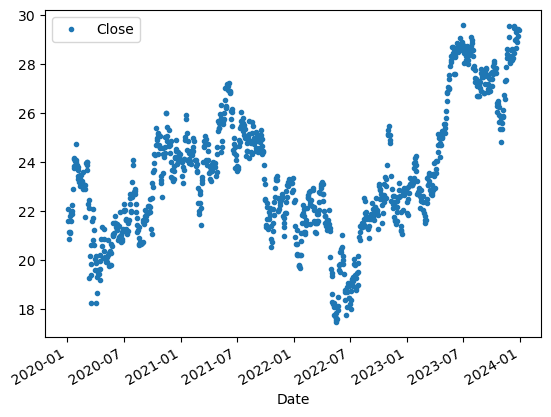

In [4]:
raia.plot(style = ".")

## Train Test Split

In [5]:
train = raia.loc[raia.index < "01-01-2023"]
test = raia.loc[raia.index >= "01-01-2023"]

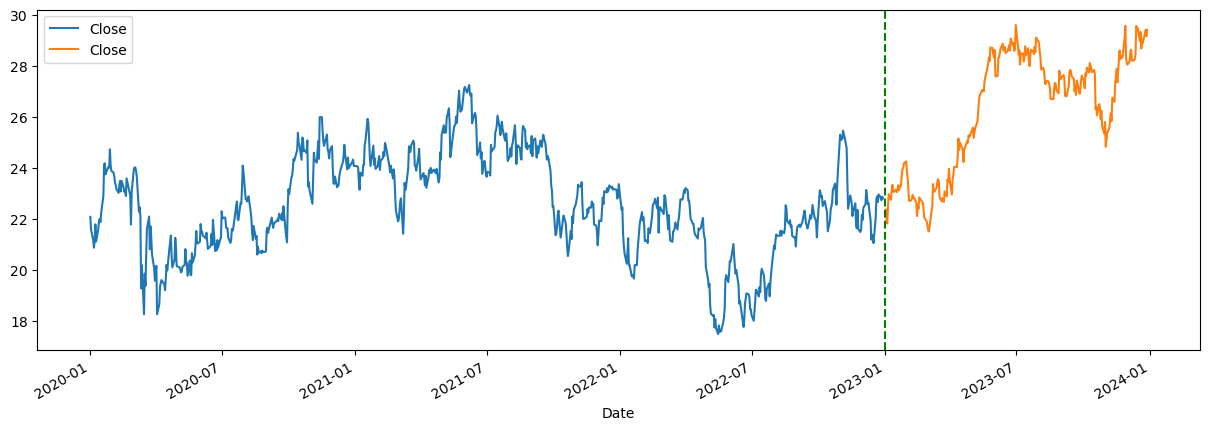

In [6]:
fig, ax = plt.subplots(figsize = (15, 5))

train.plot(ax = ax, label = "Training Set")
test.plot(ax = ax, label = "Test Set")

ax.axvline("01-01-2023", color = "green", ls = "--")

plt.show()

<Axes: xlabel='Date'>

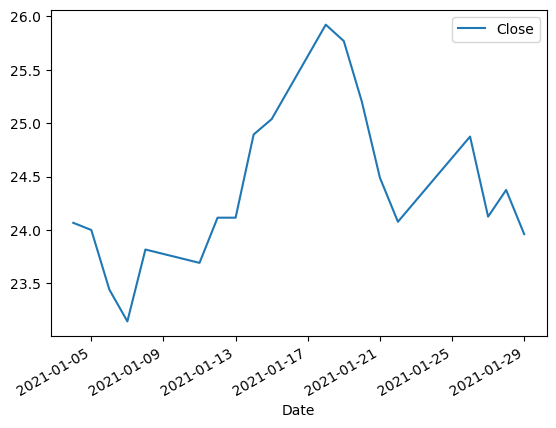

In [7]:
raia.loc[(raia.index > "01-01-2021") & (raia.index < "02-01-2021")].plot()

## Feature Creation

https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html

https://pandas.pydata.org/docs/user_guide/timeseries.html

In [8]:
def create_features(raia):
    """
    Create time series features 
    """
    raia = raia.copy()
    raia["quarter"] = raia.index.quarter
    raia["month"] = raia.index.month
    raia["year"] = raia.index.year
    raia["day"] = raia.index.day

    return(raia)

In [9]:
raia = create_features(raia)

In [10]:
train = create_features(train)
test = create_features(test)


#FEATURES = ['quarter', 'month', 'year']
FEATURES = ['day']
TARGET = 'Close'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

## Visualise our features / target relationship

<Axes: xlabel='year', ylabel='Close'>

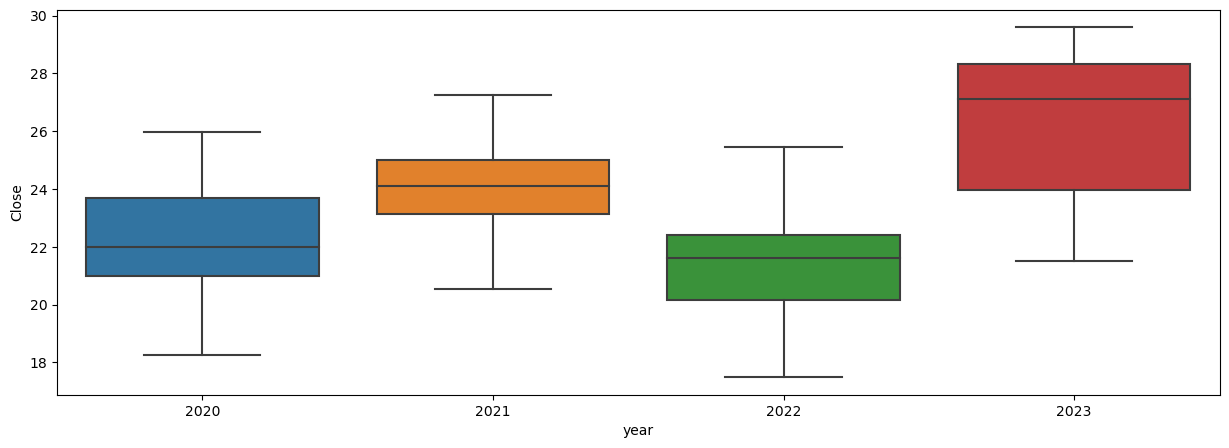

In [11]:
fig, ax = plt.subplots(figsize = (15, 5))
sns.boxplot(data = raia, x = "year", y = "Close")

<Axes: xlabel='month', ylabel='Close'>

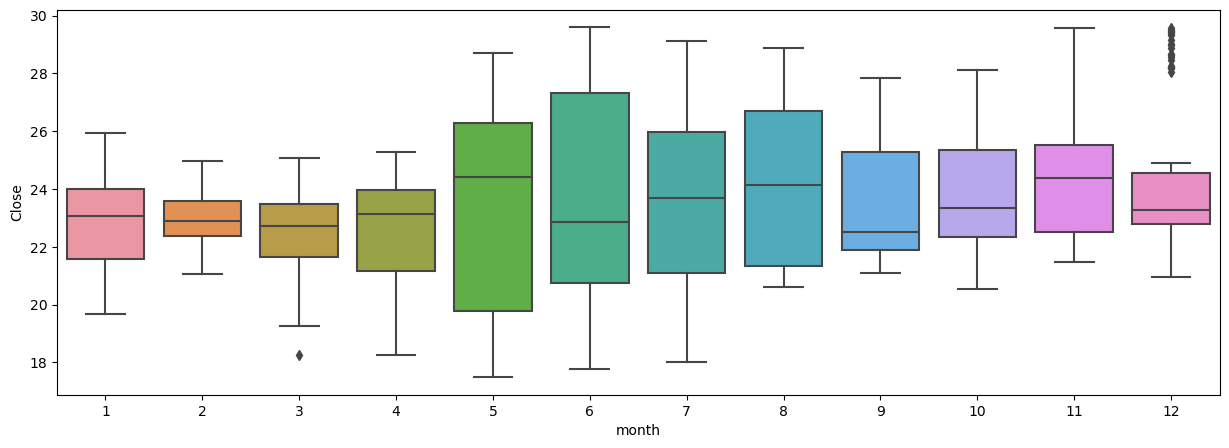

In [12]:
fig, ax = plt.subplots(figsize = (15, 5))
sns.boxplot(data = raia, x = "month", y = "Close")

## Create our model

In [13]:
reg = xgb.XGBRegressor(n_estimators = 1000, early_stopping_rounds = 50,
                      learning_rate = 0.001)
reg.fit(X_train, y_train,
       eval_set = [(X_train, y_train), (X_test, y_test)],
       verbose = 100)

[0]	validation_0-rmse:1.95496	validation_1-rmse:4.43089
[50]	validation_0-rmse:1.95440	validation_1-rmse:4.43111


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.001, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## Feature Importance

In [14]:
fi = pd.DataFrame(data = reg.feature_importances_,
             index = reg.feature_names_in_, 
                 columns = ["importance"])

In [15]:
fi

,importance
day,1.0


<Axes: >

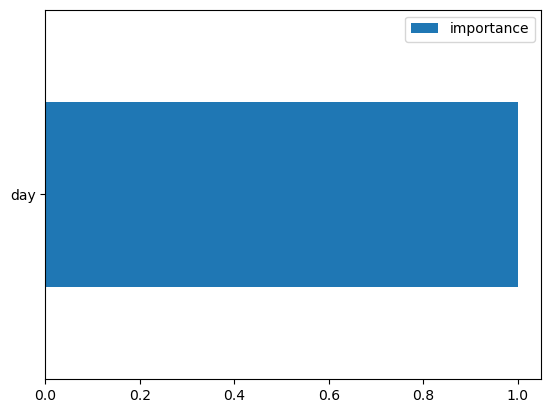

In [16]:
fi.sort_values("importance").plot(kind = "barh")

## Forecast on Test

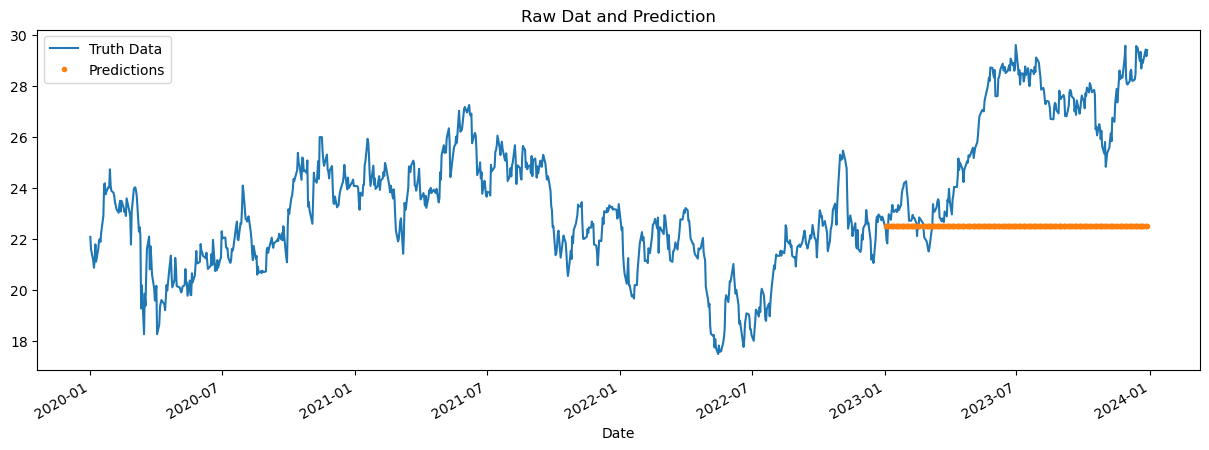

In [17]:

test['prediction'] = reg.predict(X_test)
raia = raia.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = raia[['Close']].plot(figsize=(15, 5))
test['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

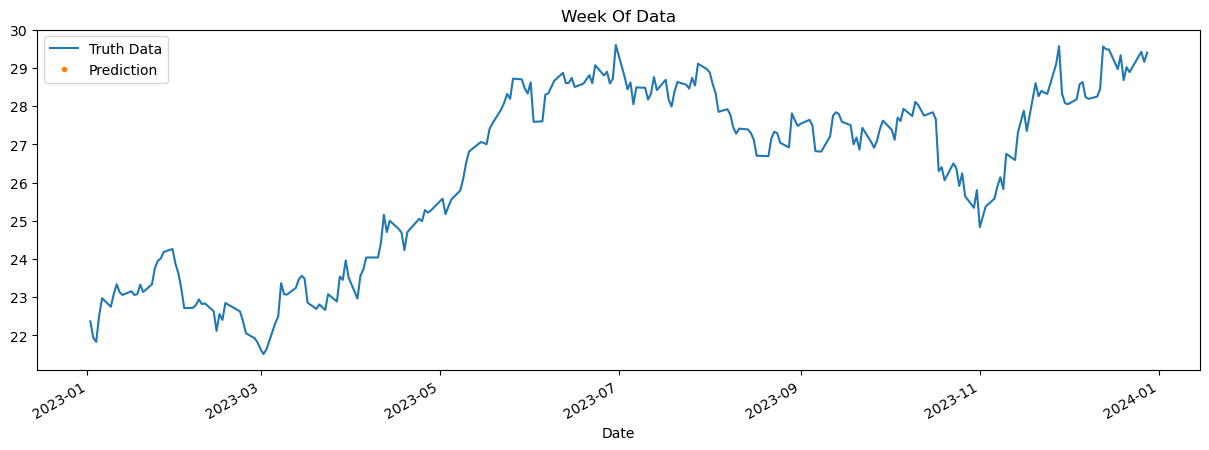

In [18]:
ax = raia.loc[(raia.index > '01-01-2023') & (raia.index < '01-01-2024')]['Close'] \
    .plot(figsize=(15, 5), title='Week Of Data')
raia.loc[(raia.index > '01-01-2023') & (raia.index < '01-01-2023')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

In [19]:
score = np.sqrt(mean_squared_error(test['Close'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 4.43


In [20]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2023-06-30    7.079090
2023-11-28    7.049212
2023-12-13    7.039566
2023-12-14    6.969235
2023-12-15    6.959235
2023-12-26    6.899212
2023-12-28    6.879212
2023-12-19    6.809235
2023-12-27    6.639212
2023-07-28    6.589213
Name: error, dtype: float64

test["prediction"] = reg.predict(X_test)

raia.merge(test[["prediction"]], how = "left", left_index = True, right_index = True)

ax = raia[["Close"]].plot()
raia["prediction"].plot(ax = ax, style = ".")